# 1.Libraries

In [1]:
# Load required libraries
import numpy as np
import pandas as pd

import math

# Custom utils from kesh-utils (Check source code: https://github.com/KeshavShetty/kesh-utils)
from KUtils.common import utils
from KUtils.eda import chartil
from KUtils.eda import data_preparation as dp
from KUtils.classifier import generic_classifier_utils as gcu
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, recall_score, precision_score

from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# General imports
import os, sys, gc, warnings, random, datetime

# 2.Load Data

In [2]:
#https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/

# Train data 
train_df = pd.read_csv('train.csv')
# Train data 
item_df = pd.read_csv('item_data.csv')
# Train data 
log_df = pd.read_csv('view_log.csv')
# Test data
test_df = pd.read_csv('test.csv')

# 2.1 Input data information

<P> train.csv : This file contains the add impression logs from the server where the add was shown. </p>
<P>view_log.csv : This file contains user view logs from server. </p> 
<P>item_data.csv : This file contains the items metadata. </p>
<P>test.csv: test file contains the impressions for which the participants need to predict the click rate. </p>
<P>sample_submission.csv: This file contains the format in which you have to submit your predictions. </p>

In [3]:
print(train_df.shape)
print(log_df.shape)
print(item_df.shape)
print(test_df.shape)

(237609, 7)
(3118622, 5)
(132761, 6)
(90675, 6)


In [4]:
# Show all column in head()
pd.set_option('display.max_columns', None)

In [5]:
item_df.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [6]:
log_df.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [7]:
train_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


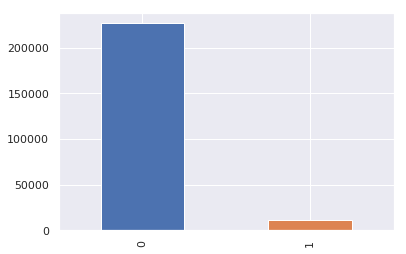

In [8]:
train_df['is_click'].value_counts().plot(kind='bar')

In [9]:
print('Click percentage :', train_df['is_click'].value_counts()[1]/train_df['is_click'].value_counts().sum()*100 , '%')

Click percentage : 4.571375663379754 %


# 3.Data preprocessing

<p>Here is a limitation that we have huge no.of logs for each user and the target column was exists at train.csv.</p>
<p>So we cannot directly merge all the 3 tables.</p>
<p>So what i did is i merged initially view_log.csv and item_data.csv and then some FE on resulted tables.</p>

In [10]:
#Merging log_df and item_df
temp_df= pd.merge(log_df, item_df, how='left', on='item_id')
print(temp_df.shape)

(3118622, 10)


In [11]:
temp_df.head(5)

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [12]:
temp_df.isna().any()[lambda x: x]

item_price      True
category_1      True
category_2      True
category_3      True
product_type    True
dtype: bool

# 3.1 Preprocessiong + Feature Engineering on train data

In [13]:

# items count per user and session
temp_df['items_count'] = temp_df.groupby(['user_id']).item_id.transform('count')
items_count_per_user = temp_df[['user_id','items_count']]

items_count_per_user = items_count_per_user.drop_duplicates(subset=['user_id','items_count'], keep='first', inplace=False)
#items_count_dct = items_count_per_user.to_dict()
dict_count = dict(zip(items_count_per_user.user_id, items_count_per_user.items_count))
#print(dict_count)
train_df['items_count']= train_df['user_id'].map(dict_count)
#test_df['items_count']= test_df['user_id'].map(dict_count)

#Apply it on test dataset as well
test_df['items_count']= test_df['user_id'].map(dict_count)

In [14]:
# Count of sessions per user
sessions_unique = temp_df.drop_duplicates(subset=['user_id','session_id'], keep='first', inplace=False)
sessions_unique['sessions_count']  = sessions_unique.groupby(['user_id','session_id']).session_id.transform('count')
#temp_df.isna().any()[lambda x: x]

sess_count_df = sessions_unique[['user_id','sessions_count']]
sessions_unique = sess_count_df.drop_duplicates(subset=['user_id','sessions_count'], keep='first', inplace=False)
sessions_count_dict = sessions_unique.to_dict()
dict_ses_count = dict(zip(sessions_unique.user_id, sessions_unique.sessions_count))
#print(dict_ses_count)
train_df['sessions_count']= train_df['user_id'].map(dict_ses_count)
#########################################################
# Apply it on test dataset as well
test_df['sessions_count']= test_df['user_id'].map(dict_ses_count)

In [15]:
# Handling missing data
temp_df['item_price'].fillna((temp_df['item_price'].mean()), inplace=True)
temp_df['category_1'] = temp_df['category_1'].fillna(temp_df['category_1'].mode().iloc[0])
temp_df['category_2'] = temp_df['category_2'].fillna(temp_df['category_2'].mode().iloc[0])
temp_df['category_3'] = temp_df['category_3'].fillna(temp_df['category_3'].mode().iloc[0])
temp_df['product_type'] = temp_df['product_type'].fillna(temp_df['product_type'].mode().iloc[0])

In [16]:
# count of product types per user
temp_df['ptype_count']  = temp_df.groupby(['user_id','product_type']).product_type.transform('count')
temp_df.isna().any()[lambda x: x]

ptypes_df = temp_df[['user_id','ptype_count']]
print(len(ptypes_df))

products_unique_df = ptypes_df.drop_duplicates(subset=['user_id','ptype_count'], keep='first', inplace=False)
prod_count_dict = products_unique_df.to_dict()
dict_prod_count = dict(zip(products_unique_df.user_id, products_unique_df.ptype_count))

products_unique_df = ptypes_df.drop_duplicates(subset=['user_id','ptype_count'], keep='first', inplace=False)
print(len(products_unique_df))
#prod_count_dict = products_unique_df.to_dict()
dict_prod_count = dict(zip(products_unique_df.user_id, products_unique_df.ptype_count))

#products_unique_df.shape
train_df['ptypes_count']= train_df['user_id'].map(dict_prod_count)
#(train_df.loc[(train_df['user_id'] == 74788) ])

# Apply it on test dataset as well
test_df['ptypes_count']= test_df['user_id'].map(dict_prod_count)
#(test_df.loc[(test_df['user_id'] == 25234) ])


3118622
284167


In [17]:
# items price mean per user 
temp_df['item_price_mean'] = temp_df.groupby(['user_id']).item_price.transform('mean')
item_price_mean = temp_df[['user_id','item_price_mean']]

item_price_mean_per_user = item_price_mean.drop_duplicates(subset=['user_id','item_price_mean'], keep='first', inplace=False)
#items_count_dct = items_count_per_user.to_dict()
dict_price_mean = dict(zip(item_price_mean_per_user.user_id, item_price_mean_per_user.item_price_mean))
#print(dict_count)
train_df['item_price_mean']= train_df['user_id'].map(dict_price_mean)

# Apply it on test dataset as well
test_df['item_price_mean']= test_df['user_id'].map(dict_price_mean)

In [18]:
# count of categories (1,2,3) per user
temp_df['c1_count']  = temp_df.groupby(['user_id','category_1']).category_1.transform('count')
temp_df.isna().any()[lambda x: x]

c1_df = temp_df[['user_id','c1_count']]
print(len(c1_df))

c1_unique_df = c1_df.drop_duplicates(subset=['user_id','c1_count'], keep='first', inplace=False)
#prod_count_dict = c1_unique_df.to_dict()
dict_c1_count = dict(zip(c1_unique_df.user_id, c1_unique_df.c1_count))


#products_unique_df.shape
train_df['c1_count']= train_df['user_id'].map(dict_c1_count)
#(train_df.loc[(train_df['user_id'] == 74788) ])

# Apply it on test dataset as well
test_df['c1_count']= test_df['user_id'].map(dict_c1_count)

3118622


In [19]:
# count of category_2  per user
temp_df['c2_count']  = temp_df.groupby(['user_id','category_2']).category_2.transform('count')
temp_df.isna().any()[lambda x: x]

c2_df = temp_df[['user_id','c2_count']]
print(len(c2_df))

c2_unique_df = c2_df.drop_duplicates(subset=['user_id','c2_count'], keep='first', inplace=False)
#c2_unique_df = c2_unique_df.to_dict()
dict_c2_count = dict(zip(c2_unique_df.user_id, c2_unique_df.c2_count))


#c2_unique_df.shape
train_df['c2_count']= train_df['user_id'].map(dict_c2_count)
#(train_df.loc[(train_df['user_id'] == 74788) ])

# Apply it on test dataset as well
test_df['c2_count']= test_df['user_id'].map(dict_c2_count)

3118622


In [20]:
# count of category_3  per user
temp_df['c3_count']  = temp_df.groupby(['user_id','category_3']).category_3.transform('count')
temp_df.isna().any()[lambda x: x]

c3_df = temp_df[['user_id','c3_count']]
print(len(c3_df))

c3_unique_df = c3_df.drop_duplicates(subset=['user_id','c3_count'], keep='first', inplace=False)
#c3_unique_df = c3_unique_df.to_dict()
dict_c3_count = dict(zip(c3_unique_df.user_id, c3_unique_df.c3_count))


#c3_unique_df.shape
train_df['c3_count']= train_df['user_id'].map(dict_c3_count)
#(train_df.loc[(train_df['user_id'] == 74788) ])

# Apply it on test dataset as well
test_df['c3_count']= test_df['user_id'].map(dict_c3_count)

3118622


In [21]:
# items count per user and session
train_df['app_count'] = train_df.groupby(['user_id']).app_code.transform('count')
app_count_per_user = train_df[['user_id','app_count']]

app_count_per_user.head()

app_count_per_user = app_count_per_user.drop_duplicates(subset=['user_id','app_count'], keep='first', inplace=False)
items_count_dct = items_count_per_user.to_dict()
app_count_dct = dict(zip(app_count_per_user.user_id, app_count_per_user.app_count))

# Apply it on Train and TEST
train_df['app_count'] = train_df['user_id'].map(app_count_dct)
test_df['app_count'] =  test_df['user_id'].map(app_count_dct)

In [22]:
# FE on column app_code
app_sum = train_df.groupby('app_code').is_click.sum().sort_values(ascending=False)
#train_df['app_sum'] = app_sum
app_count = train_df.groupby('app_code').is_click.count().sort_values(ascending=False)
#train_df['app_count']  = app_count
app_summary_train = app_sum/app_count
train_df['app_summary'] = app_summary_train.sort_values(ascending=False)

app_unique_df = train_df.drop_duplicates(subset=['app_code','app_summary'], keep='first', inplace=False)
#c3_unique_df = c3_unique_df.to_dict()
dict_app_count = dict(zip(app_unique_df.app_code, app_unique_df.app_summary))
#c3_unique_df.shape
test_df['app_summary']= test_df['app_code'].map(dict_app_count)

# 3.2 Preprocessiong date columns

In [23]:
# Convert to DateTime format
train_df['impression_time'] = pd.to_datetime(train_df.impression_time) 

In [24]:
def extract_impression_time(df):
    # create date column
    START_DATE = '2018-11-15'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['impression_time'] = df['impression_time'].apply(lambda x: (startdate + datetime.timedelta(seconds = 1)))
    df['DT_H'] = df['impression_time'].dt.hour
    df['DT_D'] = df['impression_time'].dt.day

    return df

In [25]:
def extract_server_time(df):
    # create date column
    START_DATE = '2018-10-15'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['server_time'] = df['server_time'].apply(lambda x: (startdate + datetime.timedelta(seconds = 1)))
    df['server_time_hour'] = df['server_time'].dt.hour
    df['server_time_minute'] = df['server_time'].dt.minute
    df['server_time_day'] = df['server_time'].dt.day 

    return df

In [26]:
temp_df = extract_server_time(temp_df)
train_df = extract_impression_time(train_df)
test_df = extract_impression_time(test_df)

In [27]:
#Dropping impression_time from both train and test
train_df.drop(['impression_time'], axis=1, inplace=True)
test_df.drop(['impression_time'], axis=1, inplace=True)

# 3.3: Label encoding on categorical data columns

In [28]:
#Dropping impression_time from both train and test
os_version_dummies = pd.get_dummies(train_df['os_version']) 
os_version_dummies = pd.get_dummies(train_df['os_version'], drop_first=False) 
train_df = pd.concat([train_df, os_version_dummies], axis=1)
train_df.drop(['os_version'], axis=1, inplace=True)

os_version_dummies = pd.get_dummies(test_df['os_version']) 
os_version_dummies = pd.get_dummies(test_df['os_version'], drop_first=False) 
test_df = pd.concat([test_df, os_version_dummies], axis=1)
test_df.drop(['os_version'], axis=1, inplace=True)

In [29]:
temp_df['device_type'] = temp_df['device_type'].astype(str)
temp_df['device_type'] = temp_df['device_type'].map({'android':1, 'iphone':0, 'web':2})
temp_df['device_type'] = temp_df['device_type'].astype(int)
temp_df_2_cols = temp_df[['user_id','device_type']]
temp_df_2_cols = temp_df_2_cols.drop_duplicates(subset=['user_id','device_type'], keep='first', inplace=False)
device_dict = dict(zip(temp_df_2_cols.user_id, temp_df_2_cols.device_type))
train_df['device_type'] = train_df['user_id'].map(device_dict)
test_df['device_type'] =  test_df['user_id'].map(device_dict)

In [30]:
# In our dialog with a model we are telling to trust or not to these values   
train_df['user_id_check'] = np.where(train_df['user_id'].isin(test_df['user_id']), 1, 0)
test_df['user_id_check']  = np.where(test_df['user_id'].isin(train_df['user_id']), 1, 0)

# 3.4: Normalization and FE on price columns

In [31]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df


In [32]:
i_cols=['item_price']
# TransactionAmt Normalization
periods = ['server_time_hour']
for df in [temp_df]:
    df = values_normalization(df, periods, i_cols)

In [33]:
price_min_max = temp_df[['user_id','item_price_server_time_hour_min_max']]
price_min_max.head()
price_min_max = price_min_max.drop_duplicates(subset=['user_id','item_price_server_time_hour_min_max'], keep='first', inplace=False)
price_min_max_dict = dict(zip(price_min_max.user_id, price_min_max.item_price_server_time_hour_min_max))

# Apply it on Train and TEST
train_df['item_price_server_time_hour_min_max'] = train_df['user_id'].map(price_min_max_dict)
test_df['item_price_server_time_hour_min_max'] =  test_df['user_id'].map(price_min_max_dict)

In [34]:
price_std_score = temp_df[['user_id','item_price_server_time_hour_std_score']]
price_std_score.head()
price_std_score = price_std_score.drop_duplicates(subset=['user_id','item_price_server_time_hour_std_score'], keep='first', inplace=False)
price_std_score_dict = dict(zip(price_std_score.user_id, price_std_score.item_price_server_time_hour_std_score))

# Apply it on Train and TEST
train_df['item_price_server_time_hour_std_score'] = train_df['user_id'].map(price_std_score_dict)
test_df['item_price_server_time_hour_std_score'] =  test_df['user_id'].map(price_std_score_dict)

In [35]:
# These columns are not adding any importance in model.so better to delete these 2 cols.
del train_df['DT_H']
del train_df['DT_D']

# delete from test
del test_df['DT_H']
del test_df['DT_D']

In [36]:
train_df.head()

,impression_id,user_id,app_code,is_4G,is_click,items_count,sessions_count,ptypes_count,item_price_mean,c1_count,c2_count,c3_count,app_count,app_summary,intermediate,latest,old,device_type,user_id_check,item_price_server_time_hour_min_max,item_price_server_time_hour_std_score
0,c4ca4238a0b923820dcc509a6f75849b,87862,422,0,0,1,1,1,2350.000000,1,1,1,3,0.082192,0,0,1,1,0,0.001749,-0.335618
1,45c48cce2e2d7fbdea1afc51c7c6ad26,63410,467,1,1,12,1,2,4452.833333,1,1,1,52,0.085714,0,1,0,1,1,0.000760,-0.389546
2,70efdf2ec9b086079795c442636b55fb,71748,259,1,0,2,1,1,1598.500000,1,1,1,9,0.067164,1,0,0,1,1,0.001655,-0.340743
3,8e296a067a37563370ded05f5a3bf3ec,69209,244,1,0,18,1,3,9963.388889,1,1,1,4,0.034424,0,1,0,1,0,0.013555,0.308133
4,182be0c5cdcd5072bb1864cdee4d3d6e,62873,473,0,0,46,1,5,8618.934783,9,4,6,16,0.000000,0,1,0,1,0,0.002101,-0.316423


In [37]:
test_df.head()

,impression_id,user_id,app_code,is_4G,items_count,sessions_count,ptypes_count,item_price_mean,c1_count,c2_count,c3_count,app_count,app_summary,intermediate,latest,old,device_type,user_id_check,item_price_server_time_hour_min_max,item_price_server_time_hour_std_score
0,a9e7126a585a69a32bc7414e9d0c0ada,44754,127,1,1,1,1,23424.000000,1,1,1,NaN,0.046154,0,1,0,1,0,0.017467,0.521442
1,caac14a5bf2ba283db7708bb34855760,29656,44,0,72,1,1,10752.375000,3,5,5,6.0,NaN,0,1,0,1,1,0.000212,-0.419437
2,13f10ba306a19ce7bec2f3cae507b698,25234,296,1,9,1,2,4974.555556,1,1,2,NaN,0.070988,0,1,0,1,0,0.001574,-0.345135
3,39c4b4dc0e9701b55a0a4f072008fb3f,22988,207,1,37,1,2,15009.297297,1,2,2,7.0,0.047619,0,1,0,1,1,0.003088,-0.262617
4,bf5a572cca75f5fc67f4b14e58b11d70,35431,242,1,28,1,3,8778.285714,1,4,3,20.0,NaN,0,1,0,1,1,0.008576,0.036667


In [38]:
# Finished EDA saving to csv to skip EDA part 
#train_df.to_csv("wns_train_df.csv", index=False)
#test_df.to_csv("wns_test_df.csv", index=False)

# 4.Model Building 
   # 4.1 LGB model

In [39]:
#### Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

########################### Vars
SEED = 42
seed_everything(SEED)

In [40]:
LOCAL_TEST = False
TARGET = 'is_click'
test_df['is_click'] = 0

#test_df[TARGET] = np.random.randint(0,1, size=len(test_df)
rm_cols = ['impression_id', TARGET]

# 4.2 Model training and predictions

In [41]:
########################### Features elimination 
# ks_2samp is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.
from scipy.stats import ks_2samp
features_check = []

columns_to_check = set(list(train_df)).difference(rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now (use local test drop),
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

print(features_columns)

['app_summary', 'app_count', 'user_id_check']
['user_id', 'app_code', 'is_4G', 'items_count', 'sessions_count', 'ptypes_count', 'item_price_mean', 'c1_count', 'c2_count', 'c3_count', 'app_count', 'app_summary', 'intermediate', 'latest', 'old', 'device_type', 'user_id_check', 'item_price_server_time_hour_min_max', 'item_price_server_time_hour_std_score']


In [42]:
# something in range 5-10
# 5 - is a common number of splits
# 10+ is too much (we will not have enough diversity in data)
# Here we will use 3 for faster training
# but you can change it by yourself
N_SPLITS = 10

In [43]:
########################### Model
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=2):
    #CV : using k-fold
    #folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
    
     #CV : using StratifiedKFold
    folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  

    tt_df = tt_df[['impression_id',target]]    
    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        if LOCAL_TEST:
            vl_data = lgb.Dataset(P, label=P_y) 
        else:
            vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        # predictions += pp_p/NFOLDS
        predictions += pp_p/N_SPLITS

        
        feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
        print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df
## -------------------

In [44]:
########################### Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [45]:
				########################### Model Train
if LOCAL_TEST:
    lgb_params['learning_rate'] = 0.01
    lgb_params['n_estimators'] = 20000
    lgb_params['early_stopping_rounds'] = 100
    test_predictions = make_predictions(train_df, test_df, features_columns, 'is_click', lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.01
    lgb_params['n_estimators'] = 500
    lgb_params['early_stopping_rounds'] = 100   
    test_predictions = make_predictions(train_df, test_df, features_columns, 'is_click', lgb_params, NFOLDS=10)

Fold: 0
213847 23762
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.850544	valid_1's auc: 0.740965
[400]	training's auc: 0.892727	valid_1's auc: 0.745412
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.907368	valid_1's auc: 0.746976
    Value                                Feature
0       0                         sessions_count
1       8                            device_type
2     191                            app_summary
3    1225                           intermediate
4    1228                                    old
5    1586                                 latest
6    1793                          user_id_check
7    2133                                  is_4G
8    5090                               c3_count
9    5284                           ptypes_count
10   5371                               c2_count
11   5958                               c1_count
12   9091  item_price_server_time_hour_std_score
13  10008        

# 5. Submission

In [46]:
if not LOCAL_TEST:
    test_predictions['is_click'] = test_predictions['prediction']
    test_predictions[['impression_id','is_click']].to_csv('lgb_submission_wns.csv', index=False)
    
    print(train_df.shape)
    print(test_df.shape)

(237609, 21)
(90675, 21)
